In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/713 Capstone Project (DA)/PMF_Raw Date_QueenSt_PM10.xlsx')

In [ ]:
def clean_data(df):
    # Numbers of dataframe columns
    num_columns = df.shape[1]

    # Keep first two columns and the last three columns
    columns_to_keep = list(range(2)) + list(range(num_columns - 3, num_columns))
    df = df.iloc[:, columns_to_keep]
    df.columns = range(df.shape[1])

    # Locate all whole row NA values
    na_indices = np.where(df.isna().all(axis=1))[0]

    # Initialize dfs
    dfs = []
    if len(na_indices) == 0:
        print("No whole row NA value")
    else:
        na_indices = list(na_indices) + [0, df.shape[0]]
        dfs = [df[na_indices[i]:na_indices[i+1]] for i in range(len(na_indices) - 1)]

    # Obtain each dataframe shape
    shapes = [df.shape for df in dfs]

    # Filter DataFrames with 20 to 25 rows
    filtered_dfs = [df for df, shape in zip(dfs, shapes) if 20 <= shape[0] < 25]

    # Drop the first row NA value of each dataframe
    for i, df in enumerate(filtered_dfs):
        if not df.empty and df.iloc[0].isna().all():
            filtered_dfs[i] = df.drop(df.index[0])

    # Rename filtered_dfs to new_dfs
    new_dfs = [df for df in filtered_dfs if 20 <= df.shape[0] < 25]

    for df in new_dfs:
        # Create a dummy column to identify each df based on its label
        df['Source1'] = df.iloc[0, 0]

        # Using 'for' to split the dummy column
        split_result = df['Source1'].str.split('for', expand=True)
        if split_result.shape[1] == 2:
            df[['Measure', 'Source']] = split_result
        else:
            raise ValueError("String format mismatch in column 'Source1'")
        df.drop('Source1', axis=1, inplace=True)

    # Each dataframe drops the first row (useless)
    for i in range(len(new_dfs)):
        if not new_dfs[i].empty:
            new_dfs[i] = new_dfs[i].iloc[2:].reset_index(drop=True)

    # Rename dataframes columns
    new_column_names = ['Species', 'Base Value', 'DISP Min', 'DISP Average', 'DISP Max', 'Measure', 'Source']
    for df in new_dfs:
        if len(df.columns) == len(new_column_names):
            df.columns = new_column_names

    return new_dfs


In [ ]:
new_dfs = clean_data(df)
new_dfs

[   Species Base Value DISP Min DISP Average  DISP Max          Measure  \
 0     PM10    0.98038  0.88299     1.118645    1.3543  Concentrations    
 1        H          0        0      10.6595    21.319  Concentrations    
 2       BC          0        0   118.014999    236.03  Concentrations    
 3       Na      81.56   47.747    84.068497    120.39  Concentrations    
 4       Mg     16.176   12.478      16.8965    21.315  Concentrations    
 5       Al     59.839   52.459    62.452499    72.446  Concentrations    
 6       Si     129.48   112.63   138.009995    163.39  Concentrations    
 7        S     66.736   55.071    66.058998    77.047  Concentrations    
 8       Cl          0        0      31.7745    63.549  Concentrations    
 9        K      10.18   8.8861     11.68505    14.484  Concentrations    
 10      Ca          0        0       17.848    35.696  Concentrations    
 11      Ti     5.5047   4.6193       5.7839    6.9485  Concentrations    
 12       V          0   

In [ ]:
def process_dfs_p3(new_dfs):
    # Filter DataFrames where 'Measure' contains 'concentrations'
    selected_dfs = [
        df for df in new_dfs
        if 'Measure' in df.columns and
           df['Measure'].notna().all() and
           (df['Measure'].str.strip().str.lower() == 'concentrations').any()
    ]

    # Calculate new columns
    for i, df_sub in enumerate(selected_dfs):
        # Ensure 'Base Value' exists and is numeric
        if 'Base Value' in df_sub.columns and len(df_sub['Base Value']) > 1:
            df_sub['Base Value'] = pd.to_numeric(df_sub['Base Value'], errors='coerce').fillna(0)
            divisor = df_sub['Base Value'].iloc[0]

            # Print each divisor
            print(f"DataFrame {i+1} divisor: {divisor}")

            if pd.notna(divisor) and divisor > 1e-10:
                # Perform calculations
                df_sub.loc[1:, 'Concentration'] = (df_sub['Base Value'].iloc[1:] / divisor) / 1000
                df_sub.loc[1:, 'Average'] = (df_sub['DISP Average'].iloc[1:] / divisor) / 1000
                df_sub.loc[1:, 'Error'] = (df_sub['DISP Min'].iloc[1:] / divisor) / 1000
                df_sub.loc[1:, 'Dispersion'] = (df_sub['DISP Max'].iloc[1:] / divisor) / 1000
            else:
                # Handle divisor as 0 or invalid
                for col in ['Concentration', 'Average', 'Error', 'Dispersion']:
                    df_sub[col] = 0
                print(f"Warning: DataFrame {i+1} divisor is 0 or invalid.")

    # Identify Exceedance DataFrames
    Exceedance_dfs = [
        df[df['Measure'].str.strip().str.lower() == 'percent of species sum']
        for df in new_dfs
        if 'Measure' in df.columns and not df.empty
    ]

    # Create exceedance mapping
    exceedance_map = {}
    for df in Exceedance_dfs:
        df['Source'] = df['Source'].str.strip()  # Remove spaces
        for _, row in df.iterrows():
            key = (row['Source'], row['Species'])
            exceedance_map[key] = row['Base Value']

    # Combine selected_dfs and exceedance_map
    for df_sub in selected_dfs:
        df_sub['Exceedance'] = float('nan')
        df_sub['Source'] = df_sub['Source'].str.strip()
        for index, row in df_sub.iterrows():
            key = (row['Source'], row['Species'])
            if key in exceedance_map:
                df_sub.at[index, 'Exceedance'] = exceedance_map[key]

    return selected_dfs


In [ ]:
selected_dfs = process_dfs_p3(new_dfs)
selected_dfs

DataFrame 1 divisor: 0.98038
DataFrame 2 divisor: 6.8224
DataFrame 3 divisor: 3.9065
DataFrame 4 divisor: 1.9049
DataFrame 5 divisor: 0.33465
DataFrame 6 divisor: 0.51442
DataFrame 7 divisor: 1.6713


[   Species  Base Value DISP Min DISP Average  DISP Max          Measure  \
 0     PM10    0.980380  0.88299     1.118645    1.3543  Concentrations    
 1        H    0.000000        0      10.6595    21.319  Concentrations    
 2       BC    0.000000        0   118.014999    236.03  Concentrations    
 3       Na   81.560000   47.747    84.068497    120.39  Concentrations    
 4       Mg   16.176000   12.478      16.8965    21.315  Concentrations    
 5       Al   59.839000   52.459    62.452499    72.446  Concentrations    
 6       Si  129.480000   112.63   138.009995    163.39  Concentrations    
 7        S   66.736000   55.071    66.058998    77.047  Concentrations    
 8       Cl    0.000000        0      31.7745    63.549  Concentrations    
 9        K   10.180000   8.8861     11.68505    14.484  Concentrations    
 10      Ca    0.000000        0       17.848    35.696  Concentrations    
 11      Ti    5.504700   4.6193       5.7839    6.9485  Concentrations    
 12       V 

In [ ]:
def pm_10_percentage(selected_dfs):
    # Select each dataframe's first row with required columns
    first_rows = [
        df.iloc[0][['Source', 'Exceedance']]
        for df in selected_dfs
        if 'Exceedance' in df.columns and 'Source' in df.columns and df.shape[0] > 0
    ]

    # Check if there are valid rows to concatenate
    if not first_rows:
        print("No valid rows found in selected_dfs.")
        return pd.DataFrame()  # Return empty DataFrame if no valid rows

    # Combine each first row into a new DataFrame
    pm_10_percentage = pd.concat(first_rows, axis=1).T  # Transpose to form a DataFrame

    # Rename columns
    pm_10_percentage.rename(columns={'Exceedance': 'Percentage'}, inplace=True)

    # Print and check result
    print("pm_10_percentage DataFrame Shape:", pm_10_percentage.shape)
    print(pm_10_percentage.head())

    return pm_10_percentage


In [ ]:
pm_10_result = pm_10_percentage(selected_dfs)
pm_10_result

pm_10_percentage DataFrame Shape: (7, 2)
            Source Percentage
0   Soil/Road dust   6.076277
0         Sea salt  42.284416
0  Diesel vehicles  24.212017
0  Biomass burning  11.806341
0     Construction   2.074121


,Source,Percentage
0,Soil/Road dust,6.076277
0,Sea salt,42.284416
0,Diesel vehicles,24.212017
0,Biomass burning,11.806341
0,Construction,2.074121
0,Petrol vehicles,3.188313
0,Sulphate/Marine diesel,10.358517


In [ ]:
def source_contribution_transformation(selected_dfs):

    transformed_dfs = [df.copy() for df in selected_dfs]

    # remove each dataframe first row
    for i, df in enumerate(transformed_dfs):
        if not df.empty:
            transformed_dfs[i] = df.iloc[1:].reset_index(drop=True)

    # remove useless columns
    columns_to_drop = ['Base Value', 'DISP Min', 'DISP Average', 'DISP Max', 'Measure']
    for i, df in enumerate(transformed_dfs):
        transformed_dfs[i] = df.drop(columns=columns_to_drop, inplace=False, errors='ignore')

    # print and check results
    for i, df in enumerate(transformed_dfs):
        print(f"Processed DataFrame {i+1} Shape: {df.shape}")
        print(df.head())
        print('-' * 40)

    return transformed_dfs


In [ ]:
transformed_dfs = source_contribution_transformation(selected_dfs)

Processed DataFrame 1 Shape: (20, 7)
  Species          Source  Concentration   Average     Error Dispersion  \
0       H  Soil/Road dust       0.000000  0.010873       0.0   0.021746   
1      BC  Soil/Road dust       0.000000  0.120377       0.0   0.240754   
2      Na  Soil/Road dust       0.083192  0.085751  0.048703   0.122799   
3      Mg  Soil/Road dust       0.016500  0.017235  0.012728   0.021742   
4      Al  Soil/Road dust       0.061037  0.063702  0.053509   0.073896   

   Exceedance  
0    0.000000  
1    0.000000  
2    3.730673  
3    7.928534  
4   64.831200  
----------------------------------------
Processed DataFrame 2 Shape: (20, 7)
  Species    Source  Concentration   Average     Error Dispersion  Exceedance
0       H  Sea salt       0.000000  0.001388       0.0   0.002776    0.000000
1      BC  Sea salt       0.000000  0.009788       0.0   0.019575    0.000000
2      Na  Sea salt       0.284182  0.285002  0.272045    0.29796   88.683517
3      Mg  Sea salt       

In [ ]:
processed_dfs = transformed_dfs
df_pm10_percentage=pm_10_result

In [ ]:
import os
import sqlite3

db_filename2 = 'pollution_data.sqlite'

# create database
def create_database_p3(db_filename2):
    if os.path.exists(db_filename2):
        os.remove(db_filename2)
        print(f"Database file {db_filename2} has been deleted.")
    else:
        print(f"Database file {db_filename2} does not exist.")

    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Species (
        SpeciesID INTEGER PRIMARY KEY AUTOINCREMENT,
        Species TEXT NOT NULL UNIQUE
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS PollutionSources (
        SourceID INTEGER PRIMARY KEY AUTOINCREMENT,
        SourceName TEXT NOT NULL UNIQUE
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Measurement (
        MeasurementID INTEGER PRIMARY KEY AUTOINCREMENT,
        SpeciesID INTEGER,
        SourceID INTEGER,
        Concentration REAL,
        Average REAL,
        Error REAL,
        Dispersion REAL,
        Exceedance REAL,
        FOREIGN KEY (SpeciesID) REFERENCES Species (SpeciesID),
        FOREIGN KEY (SourceID) REFERENCES PollutionSources (SourceID)
    )
    ''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS Pm10Percentage (
        ID INTEGER PRIMARY KEY AUTOINCREMENT,
        SourceID INTEGER,
        Percentage REAL,
        FOREIGN KEY (SourceID) REFERENCES PollutionSources (SourceID)
    )
    ''')

    conn.commit()
    conn.close()
    print(f"Database {db_filename2} created successfully.")

# verify if databased has been created?
def check_database_file(db_filename2):
    if os.path.exists(db_filename2):
        print(f"Database file {db_filename2} exists.")
    else:
        print(f"Database file {db_filename2} does not exist.")

# check database table
def verify_database_tables(db_filename2):
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables in {db_filename2}: {tables}")
    conn.close()

# verification
create_database_p3(db_filename2)  # create database
check_database_file(db_filename2)  # check database
verify_database_tables(db_filename2)  # check tables

Database file pollution_data.sqlite does not exist.
Database pollution_data.sqlite created successfully.
Database file pollution_data.sqlite exists.
Tables in pollution_data.sqlite: [('Species',), ('sqlite_sequence',), ('PollutionSources',), ('Measurement',), ('Pm10Percentage',)]


In [ ]:
import sqlite3

def insert_sources_to_database(db_filename2, processed_dfs):
    """
    Inserts source data from a list of processed DataFrames into the SQLite database.

    Parameters:
    - db_filename: str, the name of the SQLite database file.
    - processed_dfs: list of DataFrames, each DataFrame contains columns:
      ['Species', 'Source', 'Concentration', 'Average', 'Error', 'Dispersion', 'Exceedance'].
    """
    # Connect to the database
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        for df in processed_dfs:
            for index, row in df.iterrows():
                # insert values to table "PollutionSources"
                cursor.execute('INSERT OR IGNORE INTO PollutionSources (SourceName) VALUES (?)', (row['Source'],))

        # commit
        conn.commit()
    except Exception as e:
        print(f"Error inserting source data: {e}")
        # rollback when error happen
        conn.rollback()
    finally:
        # close connection
        conn.close()


db_filename2 = 'pollution_data.sqlite'
insert_sources_to_database(db_filename2, processed_dfs)

In [ ]:
import sqlite3

def insert_species_to_database(db_filename2, processed_dfs):
    """
    Inserts species data from a list of processed DataFrames into the SQLite database.

    Parameters:
    - db_filename2: str, the name of the SQLite database file.
    - processed_dfs: list of DataFrames, each DataFrame contains columns:
      ['Species', 'Source', 'Concentration', 'Average', 'Error', 'Dispersion', 'Exceedance'].
    """
    # Connect to the database
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        for df in processed_dfs:
            for index, row in df.iterrows():
                # Insert to table Species
                cursor.execute('INSERT OR IGNORE INTO Species (Species) VALUES (?)', (row['Species'],))

        # commit
        conn.commit()
    except Exception as e:
        print(f"Error inserting species data: {e}")
        # rollback when error happen
        conn.rollback()
    finally:
        # close connection
        conn.close()


db_filename2 = 'pollution_data.sqlite'
insert_species_to_database(db_filename2, processed_dfs)

In [ ]:
for i, df in enumerate(processed_dfs):
    print(f"DataFrame {i + 1}:")
    print(df.head())

DataFrame 1:
  Species          Source  Concentration   Average     Error Dispersion  \
0       H  Soil/Road dust       0.000000  0.010873       0.0   0.021746   
1      BC  Soil/Road dust       0.000000  0.120377       0.0   0.240754   
2      Na  Soil/Road dust       0.083192  0.085751  0.048703   0.122799   
3      Mg  Soil/Road dust       0.016500  0.017235  0.012728   0.021742   
4      Al  Soil/Road dust       0.061037  0.063702  0.053509   0.073896   

   Exceedance  
0    0.000000  
1    0.000000  
2    3.730673  
3    7.928534  
4   64.831200  
DataFrame 2:
  Species    Source  Concentration   Average     Error Dispersion  Exceedance
0       H  Sea salt       0.000000  0.001388       0.0   0.002776    0.000000
1      BC  Sea salt       0.000000  0.009788       0.0   0.019575    0.000000
2      Na  Sea salt       0.284182  0.285002  0.272045    0.29796   88.683517
3      Mg  Sea salt       0.023640  0.023713   0.02258   0.024846   79.050064
4      Al  Sea salt       0.002371  0

In [ ]:
def insert_measurements_to_database(db_filename2, processed_dfs):
    import sqlite3

    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        for df in processed_dfs:
            print("Processing DataFrame:")
            print(df.head())  # 打印 DataFrame 内容

            for index, row in df.iterrows():
                try:
                    # Obtain SpeciesID
                    cursor.execute('SELECT SpeciesID FROM Species WHERE Species = ?', (row['Species'],))
                    species_id = cursor.fetchone()
                    if species_id:
                        species_id = species_id[0]
                    else:
                        print(f"Species '{row['Species']}' not found in Species table.")
                        continue

                    # Obtain SourceID
                    cursor.execute('SELECT SourceID FROM PollutionSources WHERE SourceName = ?', (row['Source'],))
                    source_id = cursor.fetchone()
                    if source_id:
                        source_id = source_id[0]
                    else:
                        print(f"Source '{row['Source']}' not found in PollutionSources table.")
                        continue

                    # Insert into Measurement
                    cursor.execute('''
                    INSERT INTO Measurement (
                        SpeciesID, SourceID, Concentration, Average, Error, Dispersion, Exceedance
                    ) VALUES (?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        species_id,
                        source_id,
                        row['Concentration'],
                        row['Average'],
                        row['Error'],
                        row['Dispersion'],
                        row['Exceedance']
                    ))
                    print(f"Inserted row {index}: {row.to_dict()}")
                except Exception as row_error:
                    print(f"Error inserting row {index}: {row.to_dict()} -> {row_error}")
                    continue

        conn.commit()
        print("Data successfully inserted into Measurement table.")
    except Exception as e:
        print(f"Error during database insertion: {e}")
        conn.rollback()
    finally:
        conn.close()

db_filename2 = 'pollution_data.sqlite'
insert_measurements_to_database(db_filename2, processed_dfs)


Processing DataFrame:
  Species          Source  Concentration   Average     Error Dispersion  \
0       H  Soil/Road dust       0.000000  0.010873       0.0   0.021746   
1      BC  Soil/Road dust       0.000000  0.120377       0.0   0.240754   
2      Na  Soil/Road dust       0.083192  0.085751  0.048703   0.122799   
3      Mg  Soil/Road dust       0.016500  0.017235  0.012728   0.021742   
4      Al  Soil/Road dust       0.061037  0.063702  0.053509   0.073896   

   Exceedance  
0    0.000000  
1    0.000000  
2    3.730673  
3    7.928534  
4   64.831200  
Inserted row 0: {'Species': 'H', 'Source': 'Soil/Road dust', 'Concentration': 0.0, 'Average': 0.010872824947541056, 'Error': 0.0, 'Dispersion': 0.02174564964605561, 'Exceedance': 0.0}
Inserted row 1: {'Species': 'BC', 'Source': 'Soil/Road dust', 'Concentration': 0.0, 'Average': 0.12037679204966237, 'Error': 0.0, 'Dispersion': 0.24075358534445826, 'Exceedance': 0.0}
Inserted row 2: {'Species': 'Na', 'Source': 'Soil/Road dust', '

In [ ]:
import sqlite3

# 插入数据到 Pm10Percentage 表
def insert_pm10_percentage(db_filename2, df_pm10_percentage):
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    # 获取所有 Source 对应的 SourceID
    cursor.execute('SELECT SourceName, SourceID FROM PollutionSources')
    source_mapping = {row[0]: row[1] for row in cursor.fetchall()}

    # 定义插入逻辑
    def process_row(row):
        source_id = source_mapping.get(row['Source'])
        if source_id is not None:
            cursor.execute('''
                INSERT INTO Pm10Percentage (SourceID, Percentage)
                VALUES (?, ?)
            ''', (source_id, row['Base Value']))
        else:
            print(f"Source '{row['Source']}' not found in PollutionSources.")

    # 使用 apply 执行插入逻辑
    df_pm10_percentage.apply(process_row, axis=1)

    # 提交事务并关闭连接
    conn.commit()
    conn.close()
    print("Data inserted into Pm10Percentage.")


In [ ]:
import sqlite3


connection = sqlite3.connect(db_filename2)
cursor = connection.cursor()

# 插入数据
for index, row in df_pm10_percentage.iterrows():
    source = row['Source']
    percentage = row['Percentage']

    # 获取 SourceID
    cursor.execute("SELECT SourceID FROM PollutionSources WHERE SourceName = ?", (source,))
    result = cursor.fetchone()

    if result:  # 如果 SourceID 存在
        source_id = result[0]

        # 插入数据到 Pm10Percentage 表
        cursor.execute(
            '''
            INSERT INTO Pm10Percentage (SourceID, Percentage)
            VALUES (?, ?)
            ''',
            (source_id, percentage)
        )
    else:
        print(f"Warning: Source '{source}' not found in PollutionSources.")

# 提交事务
connection.commit()

# 关闭连接
connection.close()


In [ ]:
def validate_inserted_data(db_filename2):
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    # Check row counts in each table
    tables = ['Species', 'PollutionSources', 'Measurement','Pm10Percentage']
    for table in tables:
        cursor.execute(f'SELECT COUNT(*) FROM {table}')
        count = cursor.fetchone()[0]
        print(f"Table '{table}' contains {count} rows.")

    # Fetch a few sample rows from Measurement table
    print("Sample data from Measurement table:")
    cursor.execute('SELECT * FROM Measurement LIMIT 5')
    rows = cursor.fetchall()
    for row in rows:
        print(row)

    conn.close()

validate_inserted_data(db_filename2)

Table 'Species' contains 20 rows.
Table 'PollutionSources' contains 7 rows.
Table 'Measurement' contains 140 rows.
Table 'Pm10Percentage' contains 7 rows.
Sample data from Measurement table:
(1, 1, 1, 0.0, 0.010872824947541056, 0.0, 0.02174564964605561, 0.0)
(2, 2, 1, 0.0, 0.12037679204966237, 0.0, 0.24075358534445826, 0.0)
(3, 3, 1, 0.08319223158367164, 0.08575092994971502, 0.0487025439115445, 0.12279932271160161, 3.73067259788513)
(4, 4, 1, 0.016499724596584997, 0.01723464333604225, 0.012727717823701013, 0.021741569595462983, 7.92853355407715)
(5, 5, 1, 0.061036536853056975, 0.06370233928644851, 0.05350884350965952, 0.07389583630837022, 64.8311996459961)


In [ ]:
import sqlite3

# 连接到 SQLite 数据库
conn = sqlite3.connect("pollution_data.sqlite")
cursor = conn.cursor()

# 检查表结构
try:
    # Species 表结构
    cursor.execute("PRAGMA table_info(Species);")
    species_table_info = cursor.fetchall()
    print("Species table structure:")
    for column in species_table_info:
        print(column)

    # PollutionSources 表结构
    cursor.execute("PRAGMA table_info(PollutionSources);")
    pollution_sources_info = cursor.fetchall()
    print("\nPollutionSources table structure:")
    for column in pollution_sources_info:
        print(column)

    # Measurement 表结构
    cursor.execute("PRAGMA table_info(Measurement);")
    measurement_table_info = cursor.fetchall()
    print("\nMeasurement table structure:")
    for column in measurement_table_info:
        print(column)

    # Measurement 表结构
    cursor.execute("PRAGMA table_info(Pm10Percentage);")
    Pm10Percentage_table_info = cursor.fetchall()
    print("\nPm10Percentage table structure:")
    for column in Pm10Percentage_table_info:
        print(column)
finally:
    conn.close()


Species table structure:
(0, 'SpeciesID', 'INTEGER', 0, None, 1)
(1, 'Species', 'TEXT', 1, None, 0)

PollutionSources table structure:
(0, 'SourceID', 'INTEGER', 0, None, 1)
(1, 'SourceName', 'TEXT', 1, None, 0)

Measurement table structure:
(0, 'MeasurementID', 'INTEGER', 0, None, 1)
(1, 'SpeciesID', 'INTEGER', 0, None, 0)
(2, 'SourceID', 'INTEGER', 0, None, 0)
(3, 'Concentration', 'REAL', 0, None, 0)
(4, 'Average', 'REAL', 0, None, 0)
(5, 'Error', 'REAL', 0, None, 0)
(6, 'Dispersion', 'REAL', 0, None, 0)
(7, 'Exceedance', 'REAL', 0, None, 0)

Pm10Percentage table structure:
(0, 'ID', 'INTEGER', 0, None, 1)
(1, 'SourceID', 'INTEGER', 0, None, 0)
(2, 'Percentage', 'REAL', 0, None, 0)


In [ ]:
import sqlite3

def fetch_and_print_data(db_filename2):
    # Connect to the database
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        # Execute the query to fetch data from Measurement, Species, and PollutionSources
        cursor.execute('''
        SELECT Measurement.MeasurementID, Species.Species, PollutionSources.SourceName,
               Measurement.Concentration, Measurement.Average, Measurement.Error,
               Measurement.Dispersion, Measurement.Exceedance
        FROM Measurement
        JOIN Species ON Measurement.SpeciesID = Species.SpeciesID
        JOIN PollutionSources ON Measurement.SourceID = PollutionSources.SourceID
        ''')

        # Fetch all rows from the query
        rows = cursor.fetchall()

        # Check if any rows are returned
        if rows:
            print("Data fetched from the database:")
            print("MeasurementID, Species, SourceName, Concentration, Average, Error, Dispersion, Exceedance")
            for row in rows:
                print(row)
        else:
            print("No data found.")
    except Exception as e:
        print(f"Error fetching data: {e}")
    finally:
        # Close the database connection
        conn.close()

# Replace 'pollution_data.sqlite' with your actual database file name
db_filename2 = 'pollution_data.sqlite'
fetch_and_print_data(db_filename2)

Data fetched from the database:
MeasurementID, Species, SourceName, Concentration, Average, Error, Dispersion, Exceedance
(1, 'H', 'Soil/Road dust', 0.0, 0.010872824947541056, 0.0, 0.02174564964605561, 0.0)
(2, 'BC', 'Soil/Road dust', 0.0, 0.12037679204966237, 0.0, 0.24075358534445826, 0.0)
(3, 'Na', 'Soil/Road dust', 0.08319223158367164, 0.08575092994971502, 0.0487025439115445, 0.12279932271160161, 3.73067259788513)
(4, 'Mg', 'Soil/Road dust', 0.016499724596584997, 0.01723464333604225, 0.012727717823701013, 0.021741569595462983, 7.92853355407715)
(5, 'Al', 'Soil/Road dust', 0.061036536853056975, 0.06370233928644851, 0.05350884350965952, 0.07389583630837022, 64.8311996459961)
(6, 'Si', 'Soil/Road dust', 0.13207123768334725, 0.14077193996902831, 0.11488402456190455, 0.1666598665823456, 57.4423751831055)
(7, 'S', 'Soil/Road dust', 0.06807156408739469, 0.06738101359463697, 0.056173116546645176, 0.07858891450253983, 16.0935287475586)
(8, 'Cl', 'Soil/Road dust', 0.0, 0.03241039177991034, 0.

In [ ]:
import sqlite3
import pandas as pd

def fetch_and_format_data(db_filename2):
    # Connect to the database
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        # Execute the query to fetch data from Measurement, Species, and PollutionSources
        cursor.execute('''
        SELECT Species.Species, PollutionSources.SourceName,
               Measurement.Concentration, Measurement.Average, Measurement.Error, Measurement.Dispersion, Measurement.Exceedance
        FROM Measurement
        JOIN Species ON Measurement.SpeciesID = Species.SpeciesID
        JOIN PollutionSources ON Measurement.SourceID = PollutionSources.SourceID
        ''')

        # Fetch all rows from the query
        rows = cursor.fetchall()

        # Create a DataFrame from the query results
        df = pd.DataFrame(rows, columns=[
            'Species', 'SourceName', 'Concentration', 'Average', 'Error', 'Dispersion', 'Exceedance'])

        # Pivot the DataFrame to match the desired format
        pivot_df = df.pivot_table(index='Species', columns='SourceName', values=['Concentration', 'Average', 'Error', 'Dispersion', 'Exceedance'])

        # Reset index to make it easier to read
        pivot_df.columns = [f'{value}_{col}' for value, col in pivot_df.columns]
        pivot_df.reset_index(inplace=True)

        # Print the pivoted DataFrame
        print(pivot_df)

    except Exception as e:
        print(f"Error fetching data: {e}")
    finally:
        # Close the database connection
        conn.close()
        print("Data fetched and formatted successfully.")

# Replace 'pollution_data.sqlite' with your actual database file name
db_filename2 = 'pollution_data.sqlite'
fetch_and_format_data(db_filename2)

   Species  Average_Biomass burning  Average_Construction  \
0       Al                 0.001660              0.031154   
1       As                 0.000846              0.000910   
2       BC                 0.042181              0.373196   
3       Ba                 0.000259              0.002289   
4       Ca                 0.017710              0.490169   
5       Cl                 0.104529              0.271452   
6       Co                 0.000021              0.000646   
7       Cu                 0.001385              0.000662   
8       Fe                 0.018615              0.028073   
9        H                 0.075511              0.008794   
10       K                 0.013217              0.016380   
11      Mg                 0.007799              0.009328   
12      Mn                 0.000095              0.001023   
13      Na                 0.052373              0.060645   
14      Ni                 0.000268              0.000319   
15       S              

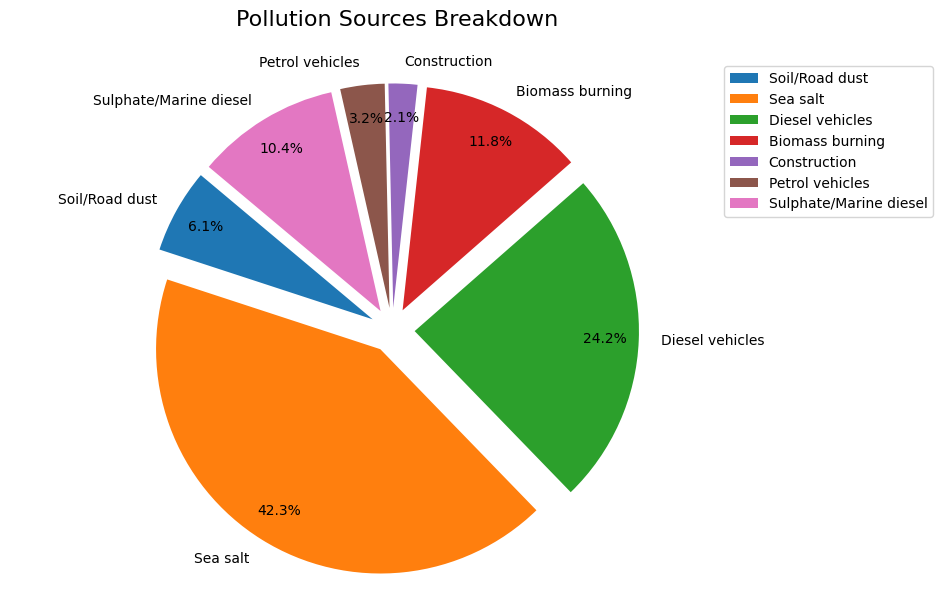

In [ ]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('pollution_data.sqlite')
cursor = conn.cursor()

# Retrieve the data for the pie chart
cursor.execute("SELECT SourceName, Percentage FROM PollutionSources JOIN Pm10Percentage ON PollutionSources.SourceID=Pm10Percentage.SourceID")
data = cursor.fetchall()

# Close the database connection
conn.close()

# Separate the data into labels and sizes
labels = [row[0] for row in data]
sizes = [row[1] for row in data]

# Create a 2D pie chart
plt.figure(figsize=(10, 7),facecolor=(1, 1, 1, 0.5))

# Create the pie chart with a slight explode effect for better visibility
explode = [0.1] * len(labels)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# Equal aspect ratio ensures the pie is drawn as a circle
plt.axis('equal')

# Add a legend
plt.legend(labels, loc='upper right', bbox_to_anchor=(1.2, 1))

# Title for the pie chart
plt.title('Pollution Sources Breakdown', fontsize=16, pad=24)

# Show the plot
plt.show()

In [ ]:
import sqlite3
import matplotlib.pyplot as plt

def plot_pie_chart(db_path):
    """
    Plots a pie chart showing the breakdown of pollution sources based on their PM10 percentages.

    Parameters:
    - db_path: str, the path to the SQLite database.

    Returns:
    - fig: matplotlib.figure.Figure, the figure object containing the pie chart.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    try:
        # Retrieve the data for the pie chart
        cursor.execute("""
        SELECT SourceName, Percentage
        FROM PollutionSources
        JOIN Pm10Percentage ON PollutionSources.SourceID = Pm10Percentage.SourceID
        """)
        data = cursor.fetchall()

        # Separate the data into labels and sizes
        labels = [row[0] for row in data]
        sizes = [row[1] for row in data]

        # Create a 2D pie chart
        fig, ax = plt.subplots(figsize=(10, 7), facecolor=(1, 1, 1, 0.5))

        # Create the pie chart with a slight explode effect for better visibility
        explode = [0.1] * len(labels)
        wedges, texts, autotexts = ax.pie(
            sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            startangle=140, pctdistance=0.85
        )

        # Equal aspect ratio ensures the pie is drawn as a circle
        ax.axis('equal')

        # Add a legend
        ax.legend(labels, loc='upper right', bbox_to_anchor=(1.2, 1))

        # Title for the pie chart
        ax.set_title('Pollution Sources Breakdown', fontsize=16, pad=24)

        return fig

    finally:
        # Close the database connection
        conn.close()

# Example usage:
# db_path = 'pollution_data.sqlite'
# fig = plot_pie_chart(db_path)
# fig.show()


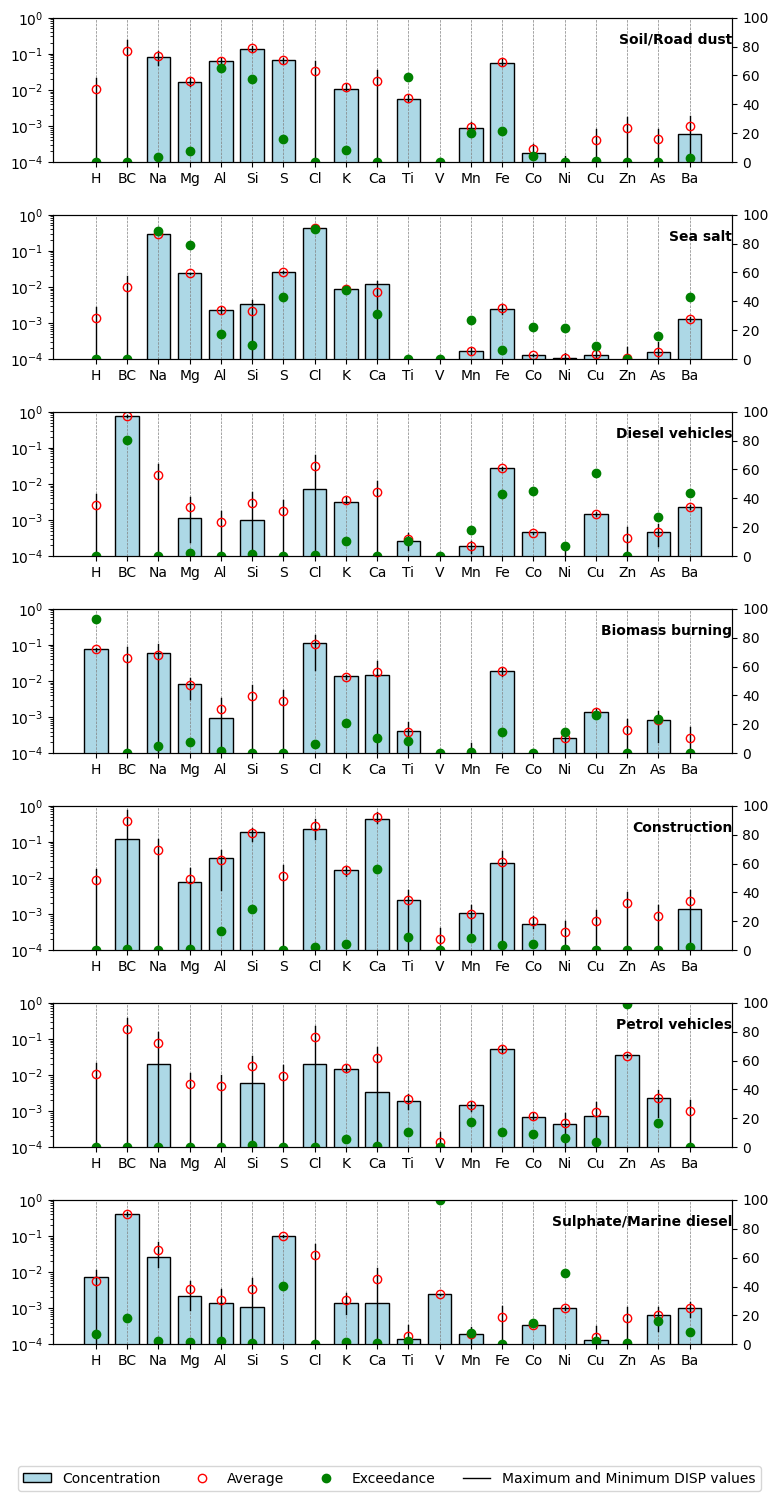

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from matplotlib.ticker import FuncFormatter

# Connect to SQLite database
conn = sqlite3.connect('pollution_data.sqlite')
cursor = conn.cursor()

# Fetch dynamic data from database
# Get all sources
cursor.execute("SELECT SourceID, SourceName FROM PollutionSources")
sources = cursor.fetchall()

# Get all species
cursor.execute("SELECT SpeciesID, Species FROM Species")
species_data = cursor.fetchall()

# Build species mapping and order
species_ids = [row[0] for row in species_data]
species_names = {row[0]: row[1] for row in species_data}

# Initialize data structure
data = {}

# Query data for each SourceID
for source_id, source_name in sources:
    cursor.execute("""
    SELECT SpeciesID, Concentration, Average, Error, Dispersion, Exceedance
    FROM Measurement
    WHERE SourceID = ?
    """, (source_id,))
    data[source_id] = {
        "name": source_name,
        "values": cursor.fetchall()
    }

# Close the database connection
conn.close()

# Plot setup
fig, axes = plt.subplots(len(sources), 1, figsize=(8, len(sources) * 2), sharex=False)
x = np.arange(len(species_ids))  # Label locations
width = 0.75  # Width of the bars

# To keep track of whether to add the legend
first_plot = True

# Create handles for the legend to ensure only one set of legend items
legend_handles = []

for i, (source_id, source_info) in enumerate(data.items()):
    ax = axes[i]
    source_name = source_info["name"]
    source_data = source_info["values"]

    # Extract data for plotting
    species_values = {row[0]: row[1:] for row in source_data}
    concentration = [species_values.get(sid, (0, 0, 0, 0, 0))[0] for sid in species_ids]
    average = [species_values.get(sid, (0, 0, 0, 0, 0))[1] for sid in species_ids]
    error = [species_values.get(sid, (0, 0, 0, 0, 0))[2] for sid in species_ids]
    dispersion = [species_values.get(sid, (0, 0, 0, 0, 0))[3] for sid in species_ids]
    exceedance = [species_values.get(sid, (0, 0, 0, 0, 0))[4] for sid in species_ids]

    # Logarithmic y-axis for concentration
    ax.set_yscale('log')
    ax.set_ylim([1e-4, 1])

    # Format left y-axis ticks to display as scientific notation (10^0, 10^-2, etc.)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'$10^{{{int(np.log10(y))}}}$'))

    # Right y-axis (percentage scale) for Exceedance
    ax2 = ax.twinx()
    ax2.set_ylim([0, 100])
    ax2.set_yticks(np.arange(0, 101, 20))

    # Background vertical lines
    for j in x:
        ax.vlines(j, 1e-4, 1, colors='gray', linestyles='dashed', lw=0.5)

    # Concentration bars
    bars = ax.bar(x, concentration, width, color='lightblue', edgecolor='black')

    # Error and Dispersion as vertical lines
    line = []
    for j in range(len(x)):
        line.append(ax.plot([x[j], x[j]], [error[j], dispersion[j]], color='black', lw=1))

    # Average as hollow dots
    avg_line = ax.plot(x, average, color='red', marker='o', markersize=6, linestyle='', markerfacecolor='none')

    # Exceedance as green dots
    exceedance_line = ax2.plot(x, exceedance, color='green', marker='o', markersize=6, linestyle='')

    # Add labels to the legend only for the first plot (for each source)
    if first_plot:
        # Create handles for the legend
        legend_handles.append(bars[0])  # The light blue bars (Concentration)
        legend_handles.append(avg_line[0])  # The red hollow dots (Average)
        legend_handles.append(exceedance_line[0])  # The green dots (Exceedance)
        legend_handles.append(line[0][0])  # The black lines (Maximum and minimum DISP values)

        first_plot = False

    # Set title for each subplot (top-right corner)
    ax.text(1, 0.8, source_name, transform=ax.transAxes, ha='right', va='bottom', fontsize=10, weight='bold')

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels([species_names[sid] for sid in species_ids], rotation=0)

# Add the legend at the bottom of the entire figure (only once)
fig.legend(legend_handles, ['Concentration', 'Average', 'Exceedance', 'Maximum and Minimum DISP values'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Adjust the layout to make space for the legend
plt.tight_layout(pad=1.5)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from matplotlib.ticker import FuncFormatter

def plot_source_contribution():
    """
    Plots a detailed contribution of pollution sources across different species.

    Parameters:
    - db_path: str, the path to the SQLite database.

    Returns:
    - fig: matplotlib.figure.Figure, the figure object containing the plots.
    """
    # Connect to SQLite database
    conn = sqlite3.connect(db_filename2)
    cursor = conn.cursor()

    try:
        # Fetch dynamic data from database
        # Get all sources
        cursor.execute("SELECT SourceID, SourceName FROM PollutionSources")
        sources = cursor.fetchall()

        # Get all species
        cursor.execute("SELECT SpeciesID, Species FROM Species")
        species_data = cursor.fetchall()

        # Build species mapping and order
        species_ids = [row[0] for row in species_data]
        species_names = {row[0]: row[1] for row in species_data}

        # Initialize data structure
        data = {}

        # Query data for each SourceID
        for source_id, source_name in sources:
            cursor.execute("""
            SELECT SpeciesID, Concentration, Average, Error, Dispersion, Exceedance
            FROM Measurement
            WHERE SourceID = ?
            """, (source_id,))
            data[source_id] = {
                "name": source_name,
                "values": cursor.fetchall()
            }

    finally:
        # Close the database connection
        conn.close()

    # Plot setup
    fig, axes = plt.subplots(len(sources), 1, figsize=(8, len(sources) * 2), sharex=False)
    if len(sources) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one source

    x = np.arange(len(species_ids))  # Label locations
    width = 0.75  # Width of the bars

    # To keep track of whether to add the legend
    first_plot = True

    # Create handles for the legend to ensure only one set of legend items
    legend_handles = []

    for i, (source_id, source_info) in enumerate(data.items()):
        ax = axes[i]
        source_name = source_info["name"]
        source_data = source_info["values"]

        # Extract data for plotting
        species_values = {row[0]: row[1:] for row in source_data}
        concentration = [species_values.get(sid, (0, 0, 0, 0, 0))[0] for sid in species_ids]
        average = [species_values.get(sid, (0, 0, 0, 0, 0))[1] for sid in species_ids]
        error = [species_values.get(sid, (0, 0, 0, 0, 0))[2] for sid in species_ids]
        dispersion = [species_values.get(sid, (0, 0, 0, 0, 0))[3] for sid in species_ids]
        exceedance = [species_values.get(sid, (0, 0, 0, 0, 0))[4] for sid in species_ids]

        # Logarithmic y-axis for concentration
        ax.set_yscale('log')
        ax.set_ylim([1e-4, 1])

        # Format left y-axis ticks to display as scientific notation (10^0, 10^-2, etc.)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'$10^{{{int(np.log10(y))}}}$'))

        # Right y-axis (percentage scale) for Exceedance
        ax2 = ax.twinx()
        ax2.set_ylim([0, 100])
        ax2.set_yticks(np.arange(0, 101, 20))

        # Background vertical lines
        for j in x:
            ax.vlines(j, 1e-4, 1, colors='gray', linestyles='dashed', lw=0.5)

        # Concentration bars
        bars = ax.bar(x, concentration, width, color='lightblue', edgecolor='black')

        # Error and Dispersion as vertical lines
        line = []
        for j in range(len(x)):
            line.append(ax.plot([x[j], x[j]], [error[j], dispersion[j]], color='black', lw=1))

        # Average as hollow dots
        avg_line = ax.plot(x, average, color='red', marker='o', markersize=6, linestyle='', markerfacecolor='none')

        # Exceedance as green dots
        exceedance_line = ax2.plot(x, exceedance, color='green', marker='o', markersize=6, linestyle='')

        # Add labels to the legend only for the first plot (for each source)
        if first_plot:
            # Create handles for the legend
            legend_handles.append(bars[0])  # The light blue bars (Concentration)
            legend_handles.append(avg_line[0])  # The red hollow dots (Average)
            legend_handles.append(exceedance_line[0])  # The green dots (Exceedance)
            legend_handles.append(line[0][0])  # The black lines (Maximum and minimum DISP values)

            first_plot = False

        # Set title for each subplot (top-right corner)
        ax.text(1, 0.8, source_name, transform=ax.transAxes, ha='right', va='bottom', fontsize=10, weight='bold')

        # Set the x-axis labels
        ax.set_xticks(x)
        ax.set_xticklabels([species_names[sid] for sid in species_ids], rotation=0)

    # Add the legend at the bottom of the entire figure (only once)
    fig.legend(legend_handles, ['Concentration', 'Average', 'Exceedance', 'Maximum and Minimum DISP values'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    # Adjust the layout to make space for the legend
    plt.tight_layout(pad=1.5)

    return fig

# Example usage:
# db_path = 'pollution_data.sqlite'
# fig = plot_source_contribution(db_path)
# fig.show()


In [ ]:
def plot_source_contribution():
  # Connect to SQLite database
  conn = sqlite3.connect('pollution_data.sqlite')
  cursor = conn.cursor()

  # Fetch dynamic data from database
  # Get all sources
  cursor.execute("SELECT SourceID, SourceName FROM PollutionSources")
  sources = cursor.fetchall()

  # Get all species
  cursor.execute("SELECT SpeciesID, Species FROM Species")
  species_data = cursor.fetchall()

  # Build species mapping and order
  species_ids = [row[0] for row in species_data]
  species_names = {row[0]: row[1] for row in species_data}

  # Initialize data structure
  data = {}

  # Query data for each SourceID
  for source_id, source_name in sources:
      cursor.execute("""
      SELECT SpeciesID, Concentration, Average, Error, Dispersion, Exceedance
      FROM Measurement
      WHERE SourceID = ?
      """, (source_id,))
      data[source_id] = {
          "name": source_name,
          "values": cursor.fetchall()
      }

  # Close the database connection
  conn.close()

  # Plot setup
  fig, axes = plt.subplots(len(sources), 1, figsize=(8, len(sources) * 2), sharex=False)
  x = np.arange(len(species_ids))  # Label locations
  width = 0.75  # Width of the bars

  # To keep track of whether to add the legend
  first_plot = True

  # Create handles for the legend to ensure only one set of legend items
  legend_handles = []

  for i, (source_id, source_info) in enumerate(data.items()):
      ax = axes[i]
      source_name = source_info["name"]
      source_data = source_info["values"]

      # Extract data for plotting
      species_values = {row[0]: row[1:] for row in source_data}
      concentration = [species_values.get(sid, (0, 0, 0, 0, 0))[0] for sid in species_ids]
      average = [species_values.get(sid, (0, 0, 0, 0, 0))[1] for sid in species_ids]
      error = [species_values.get(sid, (0, 0, 0, 0, 0))[2] for sid in species_ids]
      dispersion = [species_values.get(sid, (0, 0, 0, 0, 0))[3] for sid in species_ids]
      exceedance = [species_values.get(sid, (0, 0, 0, 0, 0))[4] for sid in species_ids]

      # Logarithmic y-axis for concentration
      ax.set_yscale('log')
      ax.set_ylim([1e-4, 1])

      # Format left y-axis ticks to display as scientific notation (10^0, 10^-2, etc.)
      ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'$10^{{{int(np.log10(y))}}}$'))

      # Right y-axis (percentage scale) for Exceedance
      ax2 = ax.twinx()
      ax2.set_ylim([0, 100])
      ax2.set_yticks(np.arange(0, 101, 20))

      # Background vertical lines
      for j in x:
          ax.vlines(j, 1e-4, 1, colors='gray', linestyles='dashed', lw=0.5)

      # Concentration bars
      bars = ax.bar(x, concentration, width, color='lightblue', edgecolor='black')

      # Error and Dispersion as vertical lines
      line = []
      for j in range(len(x)):
          line.append(ax.plot([x[j], x[j]], [error[j], dispersion[j]], color='black', lw=1))

      # Average as hollow dots
      avg_line = ax.plot(x, average, color='red', marker='o', markersize=6, linestyle='', markerfacecolor='none')

      # Exceedance as green dots
      exceedance_line = ax2.plot(x, exceedance, color='green', marker='o', markersize=6, linestyle='')

      # Add labels to the legend only for the first plot (for each source)
      if first_plot:
          # Create handles for the legend
          legend_handles.append(bars[0])  # The light blue bars (Concentration)
          legend_handles.append(avg_line[0])  # The red hollow dots (Average)
          legend_handles.append(exceedance_line[0])  # The green dots (Exceedance)
          legend_handles.append(line[0][0])  # The black lines (Maximum and minimum DISP values)

          first_plot = False

      # Set title for each subplot (top-right corner)
      ax.text(1, 0.8, source_name, transform=ax.transAxes, ha='right', va='bottom', fontsize=10, weight='bold')

      # Set the x-axis labels
      ax.set_xticks(x)
      ax.set_xticklabels([species_names[sid] for sid in species_ids], rotation=0)

  # Add the legend at the bottom of the entire figure (only once)
  fig.legend(legend_handles, ['Concentration', 'Average', 'Exceedance', 'Maximum and Minimum DISP values'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

  # Adjust the layout to make space for the legend
  plt.tight_layout(pad=1.5)
  plt.show()

  return fig
